# 🧙‍♂️ Training diffusion model

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Jac-Zac/PML_DL_Final_Project/blob/master/notebooks/notebook_train_flow.ipynb)

### Initial setup ⚙️

In [1]:
import os

repo_dir = "PML_DL_Final_Project"

if not os.path.exists(repo_dir):
    !git clone https://github.com/Jac-Zac/PML_DL_Final_Project.git
else:
    print(f"Repository '{repo_dir}' already exists. Skipping clone.")

Cloning into 'PML_DL_Final_Project'...
remote: Enumerating objects: 393, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 393 (delta 70), reused 74 (delta 37), pack-reused 270 (from 1)
Receiving objects: 100% (393/393), 339.19 KiB | 21.20 MiB/s, done.
Resolving deltas: 100% (214/214), done.


In [2]:
if os.path.isdir(repo_dir):
    %cd $repo_dir
    !pip install dotenv -q
else:
    print(f"Directory '{repo_dir}' not found. Please clone the repository first.")

/content/PML_DL_Final_Project


### 📦 Imports

In [3]:
import torch
import numpy as np

from src.train.train import train
from src.utils.data import get_dataloaders
from src.utils.plots import plot_image_grid
from src.utils.environment import get_device, set_seed, load_pretrained_model

# Since on a notebook we can have nicer bars
import tqdm.notebook as tqdm

## Flow Matching implementation

In [ ]:
from typing import Optional

import torch
from torch import Tensor, nn


class FlowMatching:
    def __init__(self, img_size: int = 64, device: torch.device = torch.device("cpu")):
        self.img_size = img_size
        self.device = device

    def _sample_timesteps(self, batch_size: int) -> Tensor:
        return torch.rand(batch_size, device=self.device)

    def perform_training_step(
        self,
        model: nn.Module,
        x0: Tensor,  # noise ~ N(0,I)
        x1: Tensor,  # data in [-1,1]
        y: Optional[Tensor] = None,
    ) -> Tensor:
        B = x0.size(0)
        t = self._sample_timesteps(B)
        t4 = t.view(-1, 1, 1, 1)
        x_t = (1 - t4) * x0 + t4 * x1  # linear OT path

        # True velocity & normalization
        u = x1 - x0
        norm = u.flatten(1).norm(dim=1, keepdim=True).view(-1, 1, 1, 1).clamp(min=1e-6)
        u = u / norm

        v = model(x_t, t, y=y)
        assert v.shape == u.shape

        # Time-weighted MSE loss
        w = t4.pow(2)
        return (w * (v - u).pow(2)).mean()

    @torch.no_grad()
    def sample(
        self,
        model: nn.Module,
        x_init: Optional[Tensor] = None,
        steps: int = 100,
        y: Optional[Tensor] = None,
        log_intermediate: bool = False,
        t_sample_times: Optional[list[int]] = None,
    ) -> list[Tensor]:
        model.eval()
        B = (
            y.shape[0]
            if y is not None
            else (x_init.shape[0] if x_init is not None else 1)
        )
        C = x_init.shape[1] if x_init is not None else 1
        x_t = (
            x_init.to(self.device)
            if x_init is not None
            else torch.randn(B, C, self.img_size, self.img_size, device=self.device)
        )

        results = []
        dt = 1.0 / steps
        for i in range(steps):
            t = torch.full((B,), i / steps, device=self.device)
            v = model(x_t, t, y=y)
            x_t = x_t + v * dt
            if log_intermediate and t_sample_times and i in t_sample_times:
                results.append(self.transform_sampled_image(x_t.clone()))

        results.append(self.transform_sampled_image(x_t))
        return results

    @staticmethod
    def transform_sampled_image(image: Tensor) -> Tensor:
        return (image.clamp(-1, 1) + 1) / 2


### 🛠️ Configuration Parameters

In [4]:
epochs = 20
batch_size = 128
learning_rate = 2e-3
seed = 1337
checkpoint = None  # e.g., "checkpoints/last.ckpt"
model_name = "unet"
method = "flow"  # or "flow"

### 🧪 Setup: Seed and Device

In [5]:
set_seed(seed)
device = get_device()
os.makedirs("checkpoints", exist_ok=True)

## 🧠 Model Training

#### 📥 Data Loading

In [6]:
# Returns DataLoaders that yield (image, timestep, label)
train_loader, val_loader = get_dataloaders(batch_size=batch_size)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.06MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 127kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.06MB/s]


#### Training

In [7]:
# NOTE: Currently assumes 10 classes are hardcoded
num_classes = 10
model_kwargs = {"num_classes": num_classes}

# NOTE: Instead of using train directly you can write here your custom traiing code
# You can take inspiration from train to see how the checkpoints are saved

# NOTE: You can also directly copy all the code from train a cell above this and modify it inside the notebook 
# similarly to what was done for the Flow Matching Class

# But if you use it directly you can directly use model you have from the train

# model = train(
# num_epochs=epochs,
# device=device,
# dataloader=train_loader,
# val_loader=val_loader,
# learning_rate=learning_rate,
# use_wandb=True,
# checkpoint_path=checkpoint,
# model_name=model_name,
# model_kwargs=model_kwargs,
# method=method,
# )

WANDB_API_KEY environment variable not set. Please enter your WandB API key: d8dc3ad9caae0ce9504bfcf61be898d8fbdbef18


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jacopozac (jac-zac) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



Epoch 1/20


KeyboardInterrupt: 

## 💡 Image Generation

#### 🛠️ Configuration Parameters

In [8]:
n_samples = 5
save_dir = "samples"
max_steps = 1000
model_name = "unet"
ckpt_path = "checkpoints/best_model.pth"  # or use your last checkpoint

#### 💨 Initialize Diffusion Process

Generated 5 samples with labels [0, 1, 2, 3, 4]


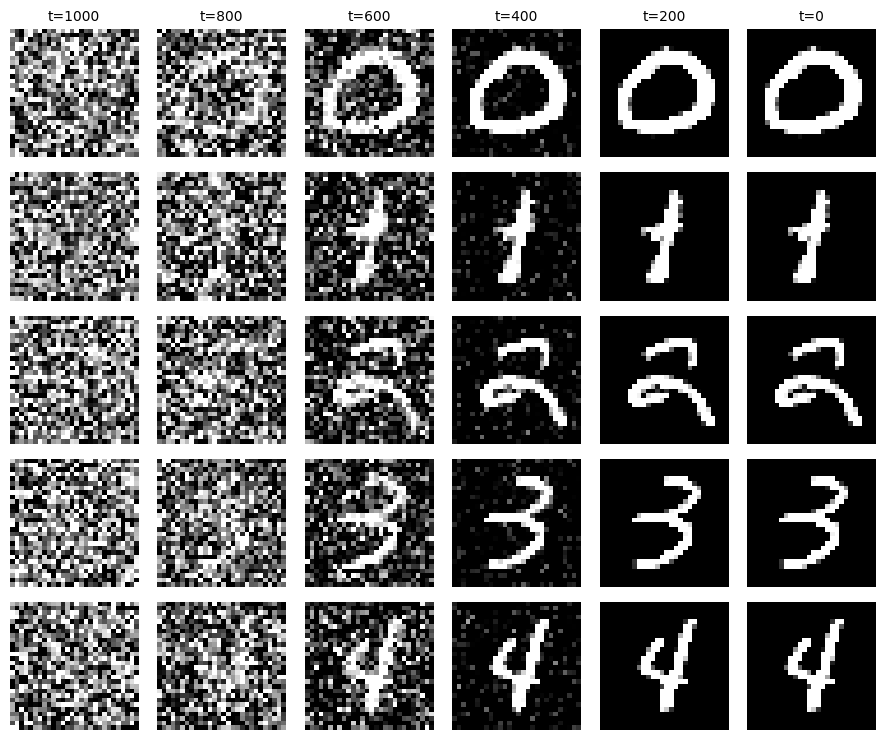

In [ ]:
from PIL import Image

# 💫 Create diffusion sampler
flow = FlowMatching(img_size=28, device=device)

# NOTE: Look into plot_image to see how it works and make it work for flow matching
# With GPT (Note the code is wrote by GPT)
# plot_image_grid(
#     model,
#     diffusion,
#     n=n_samples,
#     max_steps=max_steps,
#     save_dir=save_dir,
#     device=device,
#     num_classes=num_classes,
# )

# NOTE: Plot image saves the images inside samples (directly) by default
# So that then you can show them like this
# Display the images on the notebook
out_path = os.path.join(save_dir, "all_samples_grid.png")
display(Image.open(out_path))